In [1]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
import re

# Finance
import mplfinance as mpf
import ta
import yfinance as yf

# ML
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from torch.optim import Adam

# Analysis
import matplotlib.pyplot as plt

# System
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import sys
import time

sys.path.append('../') # Change the python path at runtime
from src.utils import path as path_yq

In [2]:
load_dotenv()
cur_dir = Path.cwd()

DEVICE = torch.device('mps')


In [3]:
datasets = ["capitaland_basic.csv", "capitaland_basic+fundamentals.csv", "capitaland+frasers+keppel_basic+fundamentals.csv"]

# for idx, data in enumerate(datasets):
#     data_name = data + 'idx'
data_dfs = []

for file in datasets:
    csv_path = Path.joinpath(path_yq.get_root_dir(cur_dir=cur_dir), 'data', file)
    df2 = pd.read_csv(csv_path, index_col=0)
    
    df2.dropna(inplace=True)
    # #print(df2.isna().sum())

    # display(df2)
    # display(df2.columns)

    data_dfs.append(df2)



In [4]:
def convert_numpy_torch(arr) -> torch:
    if isinstance(arr, (pd.DataFrame, pd.Series)):
        arr = arr.to_numpy()
    if isinstance(arr, np.ndarray):
        return torch.from_numpy(arr).float().to(DEVICE)
    else:
        raise ValueError(f"The input\n{arr}\nis not an ndarray, it is a {type(arr)}.")

# Only X needs to be turned into a sequence
def load_sequence(X, seq_len):
    sequences = []
    for i in range(len(X) - seq_len):
        sequences.append(X[i: i + seq_len])
    return np.array(sequences)

def load_data(X, y, batch_size, shuffle):
    dataset = TensorDataset(convert_numpy_torch(X),
                                convert_numpy_torch(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

class EarlyStopper:
    def __init__(self, patience=5):
        self.min_loss = np.inf
        self.patience = patience
        self.counter = 0
        self.delta = 0

    def stop(self, loss: float) -> bool:
        if loss < self.min_loss - self.delta:
            self.min_loss = loss
            # Reset counter
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [12]:
# Define the LSTM-based neural network model
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Model1, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, 
                    hidden_size=hidden_size, 
                    num_layers=num_layers, 
                    batch_first=True,
                    dropout=0.2,
                    bidirectional=False)
        # Output layer that maps the output of the LSTM to the desired output size
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x): # TODO: Removed the states and init state here
        h_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(DEVICE)
        c_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(DEVICE)
        # Forward pass through LSTM
        r_out, (h_state, c_state) = self.lstm(x, (h_state, c_state))
        return self.out(r_out[:, -1, :]), (h_state, c_state)

def plot_loss(model_dict, suptitle, title):
    model_df = pd.DataFrame(model_dict)
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_df) + 1), model_df[['train_loss']], label='Train Loss')
    plt.plot(np.arange(1, len(model_df) + 1), model_df[['val_loss']], label='Validation Loss')
    final_train_loss = model_df[['train_loss']].iloc[-1].item()
    final_val_loss = model_df[['val_loss']].iloc[-1].item()
    plt.axhline(final_train_loss, color='g', linestyle='--', label=f"{final_train_loss:.5f}")
    plt.axhline(final_val_loss, color='r', linestyle='--', label=f"{final_val_loss:.5f}")
    plt.suptitle(suptitle)
    plt.title(title)
    plt.xlabel(f"Epoch")
    plt.ylabel(f"RMSE Loss")
    plt.legend()
    combined_title = (title + '_' + suptitle).lower()
    final_title = combined_title.replace(' ', '_').replace('\n', '_')
    final_title = re.sub(r'_{2,}', '_', final_title)
    target_path = Path.joinpath(path_yq.get_root_dir(cur_dir=cur_dir), 'plots', f"{final_title}.png")
    # plt.savefig(target_path) # TODO: 2 places plt
    plt.show() 
    plt.close()

def plot_pred_actual(actual_list, pred_list, suptitle, title):
    assert len(actual_list) == len(pred_list), "Actual and predicted length different."
    # The timing might be different because of the drop last etc.
    plt.figure(figsize=(10, 6))
    plt.plot(pred_list, label='Predict', c='r', alpha=0.5)
    plt.plot(actual_list, label='Actual', c='b', alpha=0.5)
    plt.suptitle(f"{suptitle}")
    plt.title(f"{title}")
    plt.xlabel(f"Time Steps")
    plt.ylabel(f"Price")
    plt.legend()
    plt.tight_layout()
    combined_title = (title + '_' + suptitle).lower()
    final_title = combined_title.replace(' ', '_').replace('\n', '_')
    final_title = re.sub(r'_{2,}', '_', final_title)  
    target_path = Path.joinpath(path_yq.get_root_dir(cur_dir=cur_dir), 'plots', f"{final_title}.png")
    # plt.savefig(target_path)
    plt.show()
    plt.close()

In [26]:
def hp_tuning(**kwargs):
    df = kwargs.get('df')
    df_id = kwargs.get('df_id')
    seq_len = kwargs.get('seq_len')
    scaler_type = kwargs.get('scaler_type')
    lr = kwargs.get('lr')
    hidden_size = kwargs.get('hidden_size')
    num_layers = kwargs.get('num_layers')

    # Fixed params
    batch_size = 8 # Tested 8 instead of 1
    patience = 10
    n_epoch = 50
    n_splits = 2

    target_col_name = 'A17U.SI_Next_Close'
    X = df.drop(columns=[target_col_name])
    y = df[target_col_name]

    tscv = TimeSeriesSplit(n_splits=n_splits, gap=0)

    for tscv_idx, (train_idx, val_idx) in enumerate(tscv.split(X.iloc[:])):
        print(f"-----Training for data_{df_id}, seq_len={seq_len}, scaler={scaler_type}, (train_len,val_len)={len(train_idx),len(val_idx)}, lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}-----")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Unsupported scaler type: {scaler_type}.")
        X_train_scaled = scaler.fit_transform(X_train) # Scale around 0 to avoid constant predictions
        X_val_scaled = scaler.transform(X_val)
        
        # Not using drop last since the batch size is 1 so all batches will have equal size
        train_dataloader = load_data(load_sequence(X_train_scaled, seq_len), y_train[seq_len:], batch_size, shuffle=False) 
        for inputs, labels in train_dataloader:
            print("Train dataloader: batch size: {}, sequence length: {}, n_features: {}."
                .format(inputs.shape[0], inputs.shape[1], inputs.shape[2]))
            break

        # After scaling it returns numpy array
        last_n_rows = X_train_scaled[-seq_len:]
        X_val_extended = np.concatenate([last_n_rows, X_val_scaled])
        assert len(X_val_extended) - seq_len == len(y_val), \
            "Length of X_val_extended and y_val are diff: {}, {}".format(len(X_val_extended), len(y_val))
        val_dataloader = load_data(load_sequence(X_val_extended, seq_len), y_val, batch_size, shuffle=False)

        # Initialize the neural network, transfer it to GPU if available
        model = Model1(input_size=X.shape[-1], hidden_size=hidden_size, num_layers=num_layers).to(DEVICE)

        # Define a loss function and the optimizer 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        earlyStopper = EarlyStopper(patience=patience)
        model_dict = defaultdict(list)

        start_time = time.time()
        for epoch in range(n_epoch):
            epoch_train_loss = 0
            epoch_val_loss = 0
            epoch_train_samples = 0
            epoch_val_samples = 0
            pred_list = []
            actual_list = []

            model.train()
            # Iterate over the DataLoader for training data
            for i, (inputs, labels) in enumerate(train_dataloader):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                # Initialize the hidden and cell states of LSTM after every batch
                # h_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
                # c_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, backward pass, and optimize
                prediction, (h_state, c_state) = model(inputs)
                prediction, labels = prediction.squeeze(), labels.squeeze()

                loss = criterion(prediction, labels)

                epoch_train_loss += loss.item() * inputs.shape[0]
                epoch_train_samples += inputs.shape[0]

                loss.backward()
                
                nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
                
                for name, param in model.named_parameters():
                    # print(f"requires_grad: {param.requires_grad}")
                    if param.grad is not None:
                        # print(f"Layer: {name} | Max Gradient: {param.grad.data.abs().max()}")
                        pass
                    else:
                        print(f"Gradient is None")
                
                optimizer.step()
                
                # Detach states from computation graph to prevent BPP the entire history
                h_state = h_state.detach()
                c_state = c_state.detach()

            model.eval()
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(val_dataloader):
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                    # h_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
                    # c_state = torch.zeros(num_layers, batch_size, hidden_size).to(DEVICE)
                    
                    prediction, (h_state, c_state) = model(inputs)
                    prediction, labels = prediction.squeeze(), labels.squeeze()

                    loss = criterion(prediction, labels)

                    epoch_val_loss += loss.item() * inputs.shape[0]
                    epoch_val_samples += inputs.shape[0]
                    
                    print(prediction)
                    # Scalar and list situation # TODO:
                    if prediction.dim() == 0:
                        pred_list.append(prediction.item())
                        actual_list.append(labels.item())
                    else:
                        for num in prediction.cpu().tolist():
                            pred_list.append(num)
                        for num in labels.cpu().tolist():
                            actual_list.append(num)

            # Add train, val loss to dict for each epoch
            avg_train_loss = math.sqrt(epoch_train_loss / epoch_train_samples)
            avg_val_loss = math.sqrt(epoch_val_loss / epoch_val_samples)

            model_dict['train_loss'].append(avg_train_loss)
            model_dict['val_loss'].append(avg_val_loss)

            if (epoch + 1) % 10 == 0:
                # Plot predicted vs actual for certain epochs
                suptitle = f"Actual vs Predicted for Epoch {epoch + 1}"
                title = f"data_{df_id}, seq_len={seq_len}, scaler={scaler_type}, (train_len,val_len)={len(train_idx),len(val_idx)}, \
                    \nlr={lr}, hidden_size={hidden_size}, num_layers={num_layers}"
                plot_pred_actual(actual_list=actual_list, pred_list=pred_list, suptitle=suptitle, title=title)
            
            if (earlyStopper.stop(loss=avg_val_loss) == True) or (epoch == n_epoch - 1):
                # Plot the predicted vs actual for final epoch
                print(f"Stopping at epoch {epoch + 1}.")
                suptitle = f"Actual vs Predicted for Epoch {epoch + 1}"
                title = f"data_{df_id}, seq_len={seq_len}, scaler={scaler_type}, (train_len,val_len)={len(train_idx),len(val_idx)}, \
                    \nlr={lr}, hidden_size={hidden_size}, num_layers={num_layers}, stopping_epoch={epoch + 1}"
                plot_pred_actual(actual_list=actual_list, pred_list=pred_list, suptitle=suptitle, title=title)
                break
        
        # Compute duration used
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        min, sec = int(min), int(sec)
        print(f"Elapsed time is {min}m{sec}s.")
        # After all epoch ends for one config
        plot_loss(model_dict=model_dict, suptitle="Train vs Validation RMSE Loss", 
                title = f"data_{df_id}, seq_len={seq_len}, scaler={scaler_type}, (train_len,val_len)={len(train_idx),len(val_idx)}, \
                    \nlr={lr}, hidden_size={hidden_size}, num_layers={num_layers}, duration={min}m{sec}s")
        print('Finished Training')

-----Training for data_0, seq_len=20, scaler=standard, (train_len,val_len)=(274, 273), lr=1e-05, hidden_size=128, num_layers=8-----
Train dataloader: batch size: 8, sequence length: 20, n_features: 9.
tensor([0.1529, 0.1928, 0.1912, 0.2251, 0.1671, 0.2022, 0.2135, 0.0920],
       device='mps:0')
tensor([0.1549, 0.1844, 0.1378, 0.1636, 0.1267, 0.1181, 0.1754, 0.1346],
       device='mps:0')
tensor([0.1565, 0.2088, 0.1165, 0.1949, 0.1507, 0.1779, 0.1350, 0.1890],
       device='mps:0')
tensor([0.1689, 0.2000, 0.1184, 0.1899, 0.1552, 0.1316, 0.1065, 0.1758],
       device='mps:0')
tensor([0.1346, 0.1853, 0.1023, 0.1615, 0.1396, 0.1635, 0.0961, 0.2334],
       device='mps:0')
tensor([0.1676, 0.2013, 0.1438, 0.1866, 0.1804, 0.2775, 0.1444, 0.2886],
       device='mps:0')
tensor([0.1965, 0.2079, 0.1464, 0.1658, 0.2167, 0.2570, 0.1441, 0.2867],
       device='mps:0')
tensor([0.1520, 0.2078, 0.1307, 0.1552, 0.1840, 0.2396, 0.1398, 0.2641],
       device='mps:0')
tensor([0.1697, 0.2192, 0.1028,

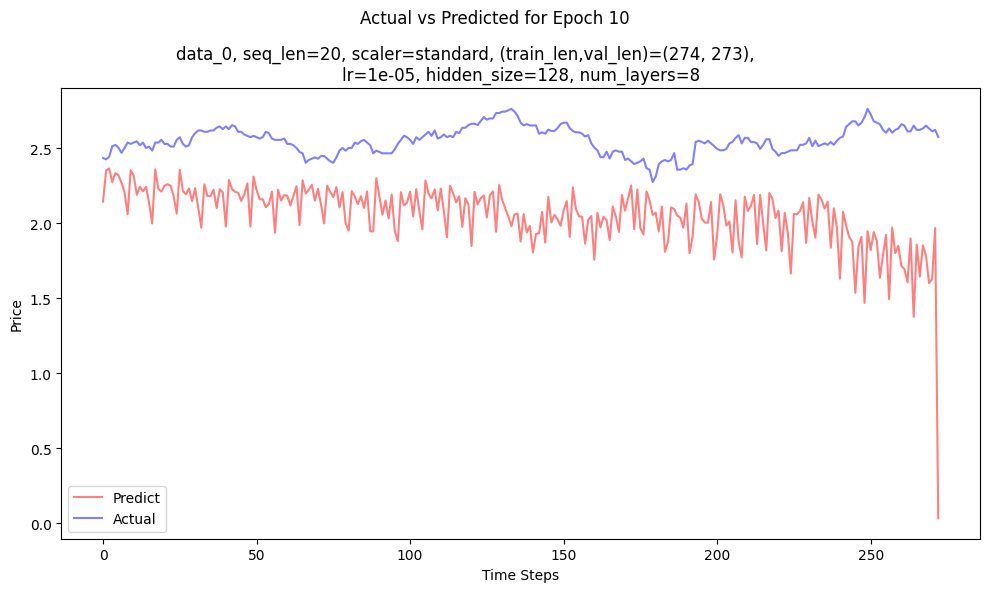

tensor([2.2074, 2.4168, 2.4302, 2.3367, 2.3956, 2.3820, 2.3316, 2.2736],
       device='mps:0')
tensor([2.1237, 2.4147, 2.3838, 2.2543, 2.3070, 2.2767, 2.3049, 2.2037],
       device='mps:0')
tensor([2.0597, 2.4242, 2.2960, 2.2756, 2.3137, 2.3248, 2.3103, 2.2496],
       device='mps:0')
tensor([2.1255, 2.4221, 2.2843, 2.2597, 2.2983, 2.2127, 2.2953, 2.1742],
       device='mps:0')
tensor([2.0342, 2.3277, 2.2506, 2.2469, 2.2902, 2.1656, 2.2895, 2.2723],
       device='mps:0')
tensor([2.0390, 2.3550, 2.2961, 2.2737, 2.2718, 2.2104, 2.2529, 2.3306],
       device='mps:0')
tensor([2.0405, 2.3776, 2.2889, 2.2241, 2.2292, 2.1684, 2.1917, 2.2756],
       device='mps:0')
tensor([2.0033, 2.2919, 2.2196, 2.2520, 2.2516, 2.1805, 2.2435, 2.3131],
       device='mps:0')
tensor([2.0505, 2.3513, 2.2667, 2.2874, 2.3236, 2.2156, 2.2904, 2.1929],
       device='mps:0')
tensor([2.0626, 2.3172, 2.2765, 2.2380, 2.3042, 2.1684, 2.2678, 2.0671],
       device='mps:0')
tensor([2.0106, 2.2766, 2.2455, 2.1882, 

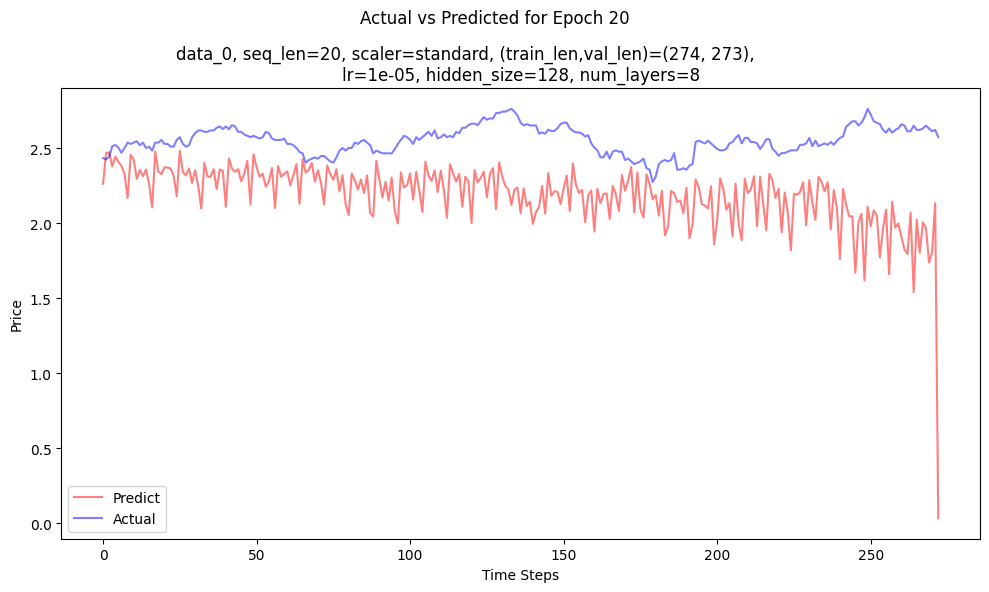

tensor([2.2645, 2.4697, 2.4721, 2.3783, 2.4442, 2.4076, 2.3823, 2.3298],
       device='mps:0')
tensor([2.1689, 2.4570, 2.4227, 2.2960, 2.3569, 2.3125, 2.3592, 2.2628],
       device='mps:0')
tensor([2.1061, 2.4798, 2.3462, 2.3274, 2.3753, 2.3705, 2.3666, 2.3201],
       device='mps:0')
tensor([2.1815, 2.4845, 2.3422, 2.3208, 2.3677, 2.2692, 2.3560, 2.2529],
       device='mps:0')
tensor([2.1000, 2.4055, 2.3158, 2.3109, 2.3645, 2.2303, 2.3611, 2.3539],
       device='mps:0')
tensor([2.1125, 2.4354, 2.3664, 2.3462, 2.3653, 2.2819, 2.3351, 2.4202],
       device='mps:0')
tensor([2.1289, 2.4635, 2.3783, 2.3139, 2.3358, 2.2475, 2.2811, 2.3730],
       device='mps:0')
tensor([2.1069, 2.3868, 2.3140, 2.3346, 2.3515, 2.2556, 2.3246, 2.3992],
       device='mps:0')
tensor([2.1335, 2.4302, 2.3406, 2.3581, 2.4054, 2.2800, 2.3554, 2.2716],
       device='mps:0')
tensor([2.1293, 2.3879, 2.3288, 2.2897, 2.3618, 2.2136, 2.3223, 2.1299],
       device='mps:0')
tensor([2.0551, 2.3323, 2.2857, 2.2244, 

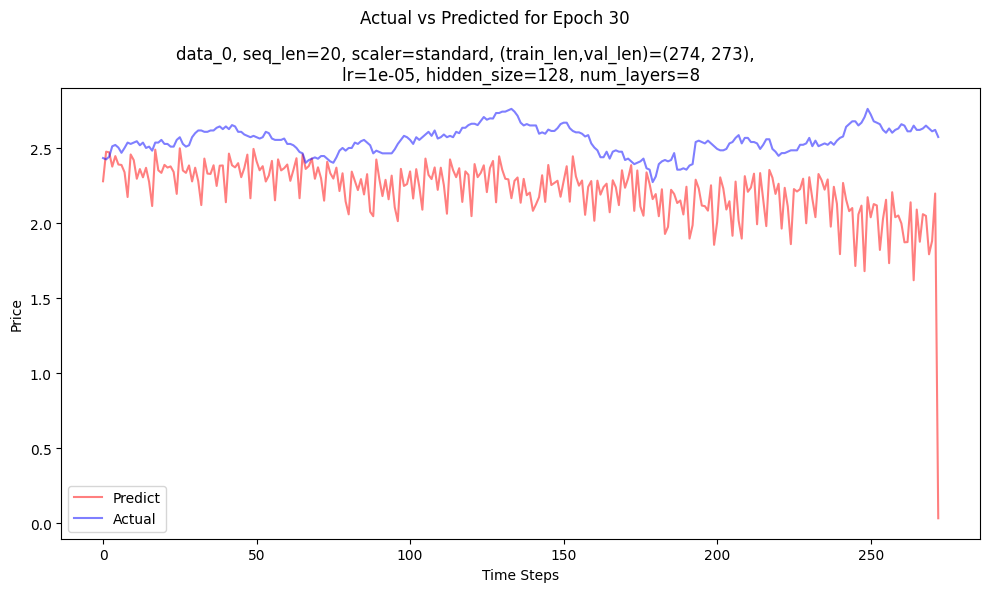

tensor([2.2819, 2.4781, 2.4728, 2.3778, 2.4479, 2.3904, 2.3893, 2.3417],
       device='mps:0')
tensor([2.1760, 2.4589, 2.4211, 2.2971, 2.3618, 2.3059, 2.3710, 2.2776],
       device='mps:0')
tensor([2.1163, 2.4920, 2.3544, 2.3371, 2.3907, 2.3715, 2.3804, 2.3441],
       device='mps:0')
tensor([2.1976, 2.5013, 2.3530, 2.3376, 2.3873, 2.2800, 2.3719, 2.2841],
       device='mps:0')
tensor([2.1237, 2.4337, 2.3329, 2.3307, 2.3888, 2.2509, 2.3862, 2.3885],
       device='mps:0')
tensor([2.1432, 2.4671, 2.3889, 2.3754, 2.4040, 2.3099, 2.3706, 2.4612],
       device='mps:0')
tensor([2.1705, 2.4990, 2.4172, 2.3571, 2.3847, 2.2816, 2.3218, 2.4198],
       device='mps:0')
tensor([2.1577, 2.4300, 2.3562, 2.3706, 2.3953, 2.2856, 2.3584, 2.4367],
       device='mps:0')
tensor([2.1704, 2.4616, 2.3645, 2.3835, 2.4342, 2.2983, 2.3747, 2.3028],
       device='mps:0')
tensor([2.1531, 2.4122, 2.3344, 2.2989, 2.3716, 2.2151, 2.3343, 2.1476],
       device='mps:0')
tensor([2.0602, 2.3455, 2.2822, 2.2211, 

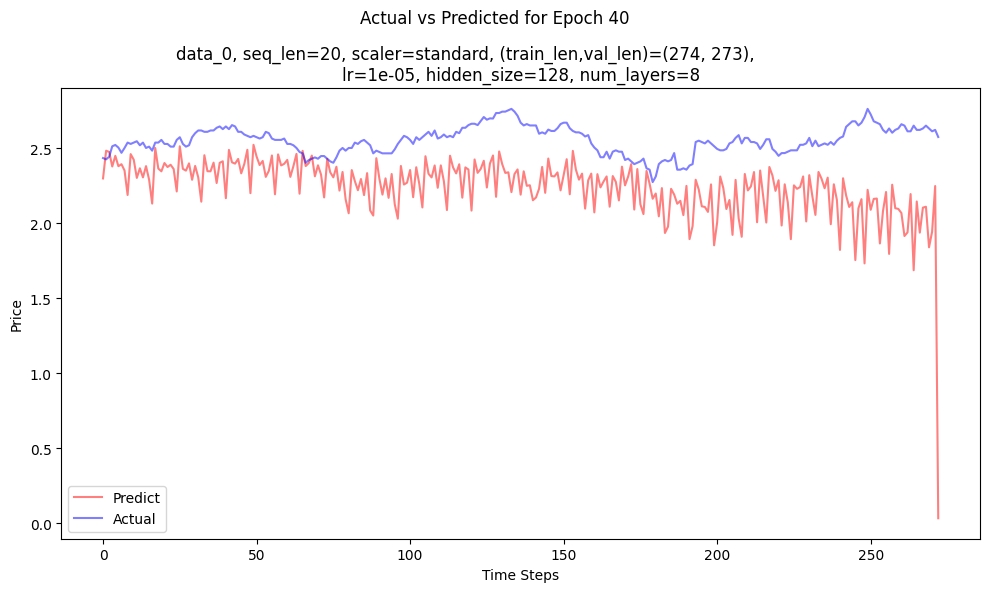

tensor([2.3008, 2.4843, 2.4758, 2.3786, 2.4496, 2.3798, 2.3942, 2.3529],
       device='mps:0')
tensor([2.1904, 2.4612, 2.4241, 2.3032, 2.3671, 2.3062, 2.3821, 2.2922],
       device='mps:0')
tensor([2.1333, 2.5027, 2.3659, 2.3475, 2.4026, 2.3755, 2.3910, 2.3633],
       device='mps:0')
tensor([2.2137, 2.5142, 2.3637, 2.3522, 2.4005, 2.2909, 2.3832, 2.3086],
       device='mps:0')
tensor([2.1461, 2.4554, 2.3485, 2.3479, 2.4057, 2.2703, 2.4048, 2.4155],
       device='mps:0')
tensor([2.1695, 2.4911, 2.4079, 2.3998, 2.4312, 2.3351, 2.3974, 2.4924],
       device='mps:0')
tensor([2.2035, 2.5252, 2.4478, 2.3911, 2.4185, 2.3121, 2.3522, 2.4550],
       device='mps:0')
tensor([2.1966, 2.4621, 2.3885, 2.3987, 2.4249, 2.3118, 2.3831, 2.4648],
       device='mps:0')
tensor([2.1997, 2.4849, 2.3829, 2.4030, 2.4529, 2.3145, 2.3874, 2.3264],
       device='mps:0')
tensor([2.1741, 2.4304, 2.3399, 2.3069, 2.3774, 2.2185, 2.3427, 2.1614],
       device='mps:0')
tensor([2.0677, 2.3555, 2.2816, 2.2205, 

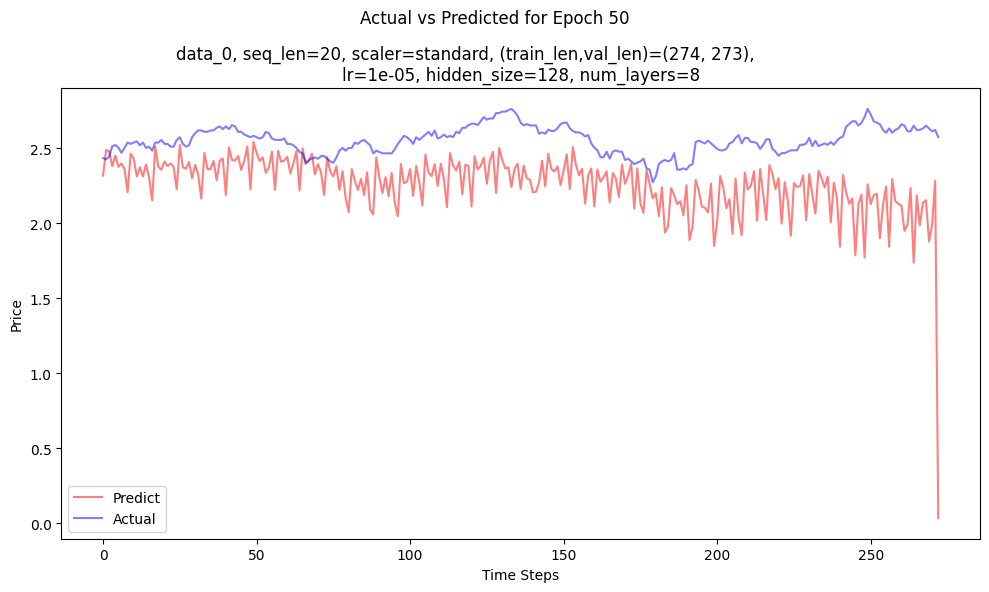

Stopping at epoch 50.


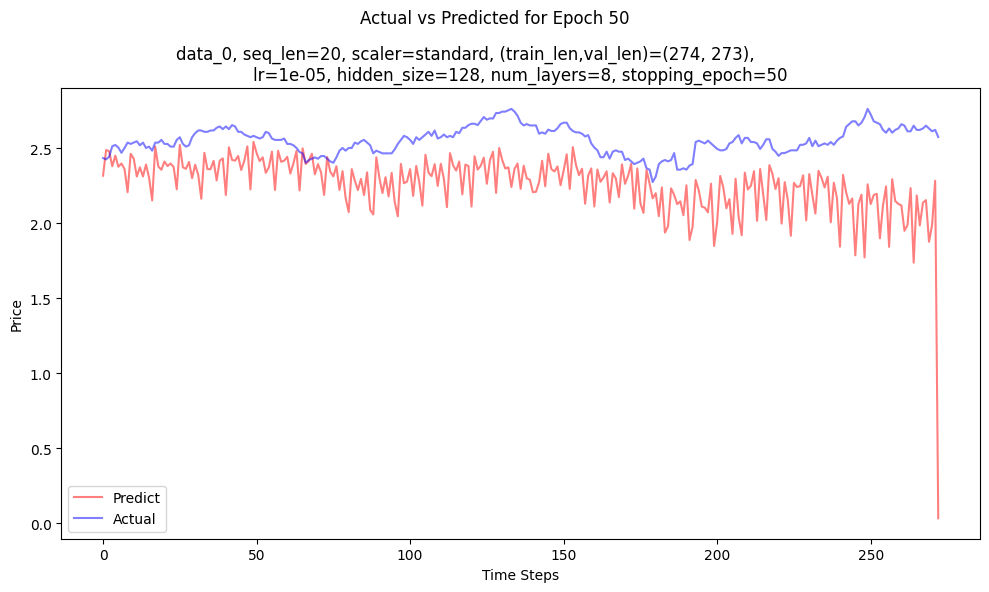

Elapsed time is 1m45s.


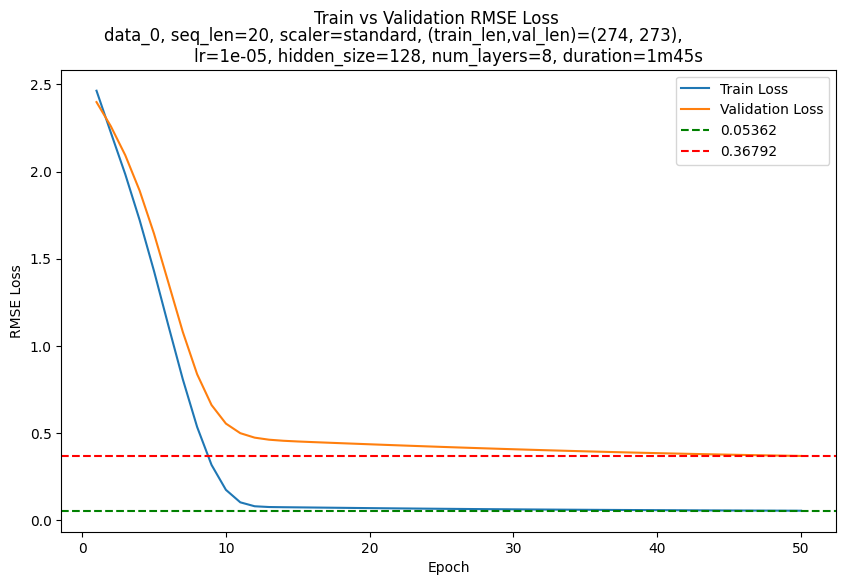

Finished Training
-----Training for data_0, seq_len=20, scaler=standard, (train_len,val_len)=(547, 273), lr=1e-05, hidden_size=128, num_layers=8-----
Train dataloader: batch size: 8, sequence length: 20, n_features: 9.
tensor([0.2993, 0.2996, 0.2995, 0.2931, 0.2980, 0.3051, 0.2974, 0.2511],
       device='mps:0')
tensor([0.2642, 0.2140, 0.2774, 0.2409, 0.2964, 0.2908, 0.2550, 0.2977],
       device='mps:0')
tensor([0.2388, 0.2965, 0.3020, 0.2711, 0.3072, 0.3406, 0.2906, 0.3340],
       device='mps:0')
tensor([0.2822, 0.3220, 0.2988, 0.2970, 0.2741, 0.2957, 0.3199, 0.3623],
       device='mps:0')
tensor([0.3393, 0.3208, 0.3088, 0.3373, 0.3214, 0.3424, 0.3354, 0.3701],
       device='mps:0')
tensor([0.3744, 0.3583, 0.3134, 0.3333, 0.2905, 0.3243, 0.3447, 0.3716],
       device='mps:0')
tensor([0.3250, 0.2979, 0.3009, 0.3239, 0.2996, 0.3243, 0.3261, 0.3456],
       device='mps:0')
tensor([0.3428, 0.3155, 0.3007, 0.2869, 0.3008, 0.3317, 0.3106, 0.3249],
       device='mps:0')
tensor([0.321

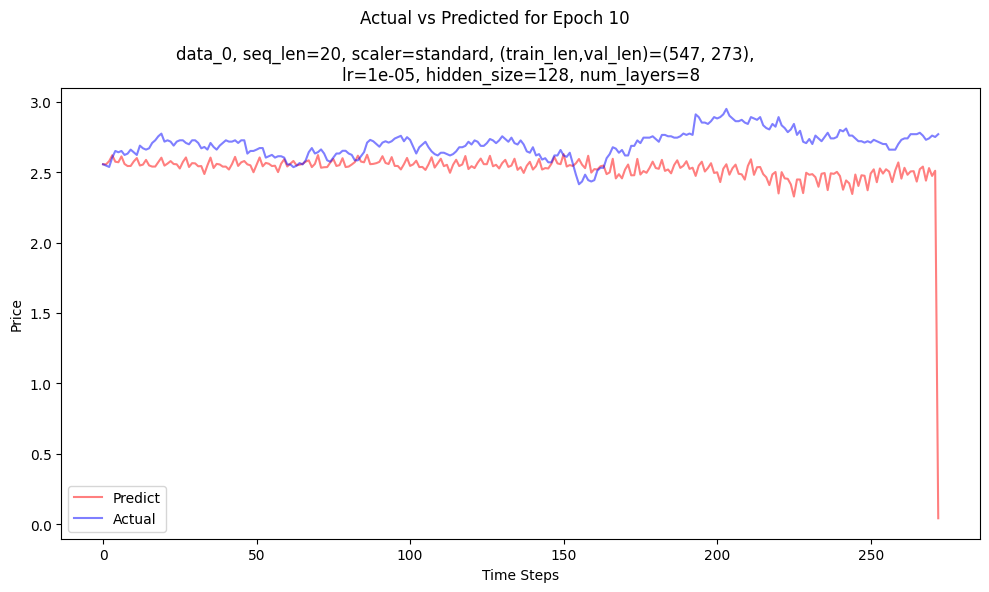

tensor([2.5617, 2.5624, 2.5823, 2.6196, 2.5774, 2.5723, 2.6092, 2.5621],
       device='mps:0')
tensor([2.5482, 2.5492, 2.5791, 2.5990, 2.5494, 2.5561, 2.5841, 2.5530],
       device='mps:0')
tensor([2.5449, 2.5465, 2.5747, 2.6040, 2.5497, 2.5646, 2.5775, 2.5647],
       device='mps:0')
tensor([2.5622, 2.5355, 2.5779, 2.6074, 2.5435, 2.5688, 2.5644, 2.5508],
       device='mps:0')
tensor([2.5518, 2.4992, 2.5566, 2.6087, 2.5380, 2.5642, 2.5568, 2.5487],
       device='mps:0')
tensor([2.5479, 2.5297, 2.5641, 2.6114, 2.5511, 2.5746, 2.5801, 2.5637],
       device='mps:0')
tensor([2.5565, 2.5110, 2.5602, 2.6087, 2.5489, 2.5706, 2.5614, 2.5519],
       device='mps:0')
tensor([2.5537, 2.5114, 2.5666, 2.5939, 2.5465, 2.5645, 2.5789, 2.5551],
       device='mps:0')
tensor([2.5591, 2.5659, 2.5786, 2.5827, 2.5378, 2.5594, 2.6174, 2.5337],
       device='mps:0')
tensor([2.5391, 2.5396, 2.5703, 2.5917, 2.5451, 2.5513, 2.5956, 2.5410],
       device='mps:0')
tensor([2.5448, 2.5600, 2.5752, 2.6173, 

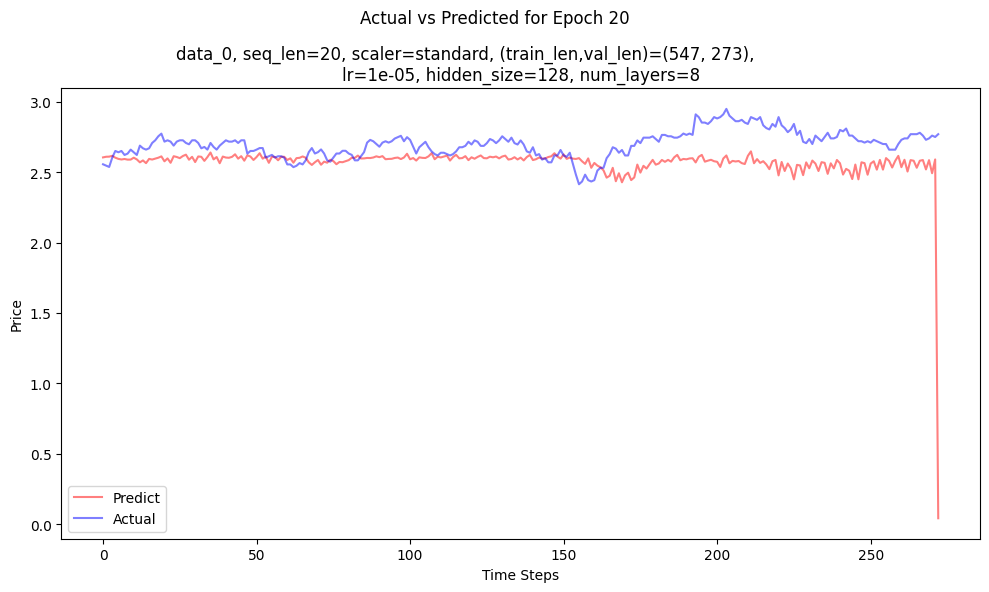

tensor([2.6078, 2.6128, 2.6120, 2.6152, 2.6047, 2.5965, 2.5889, 2.5961],
       device='mps:0')
tensor([2.5922, 2.5924, 2.6043, 2.5900, 2.5717, 2.5862, 2.5632, 2.5977],
       device='mps:0')
tensor([2.5931, 2.5999, 2.6045, 2.6126, 2.5792, 2.6007, 2.5659, 2.6166],
       device='mps:0')
tensor([2.6108, 2.6038, 2.6171, 2.6250, 2.5916, 2.6125, 2.5719, 2.6156],
       device='mps:0')
tensor([2.6126, 2.5855, 2.6108, 2.6413, 2.5940, 2.6111, 2.5634, 2.6148],
       device='mps:0')
tensor([2.6070, 2.6070, 2.6116, 2.6274, 2.5988, 2.6168, 2.5811, 2.6234],
       device='mps:0')
tensor([2.6144, 2.5917, 2.6109, 2.6358, 2.5990, 2.6140, 2.5663, 2.6135],
       device='mps:0')
tensor([2.6108, 2.5894, 2.6112, 2.6102, 2.5891, 2.6010, 2.5660, 2.6025],
       device='mps:0')
tensor([2.6043, 2.6143, 2.6038, 2.5683, 2.5522, 2.5717, 2.5839, 2.5545],
       device='mps:0')
tensor([2.5774, 2.5696, 2.5891, 2.5777, 2.5577, 2.5749, 2.5691, 2.5812],
       device='mps:0')
tensor([2.5884, 2.6057, 2.6033, 2.6177, 

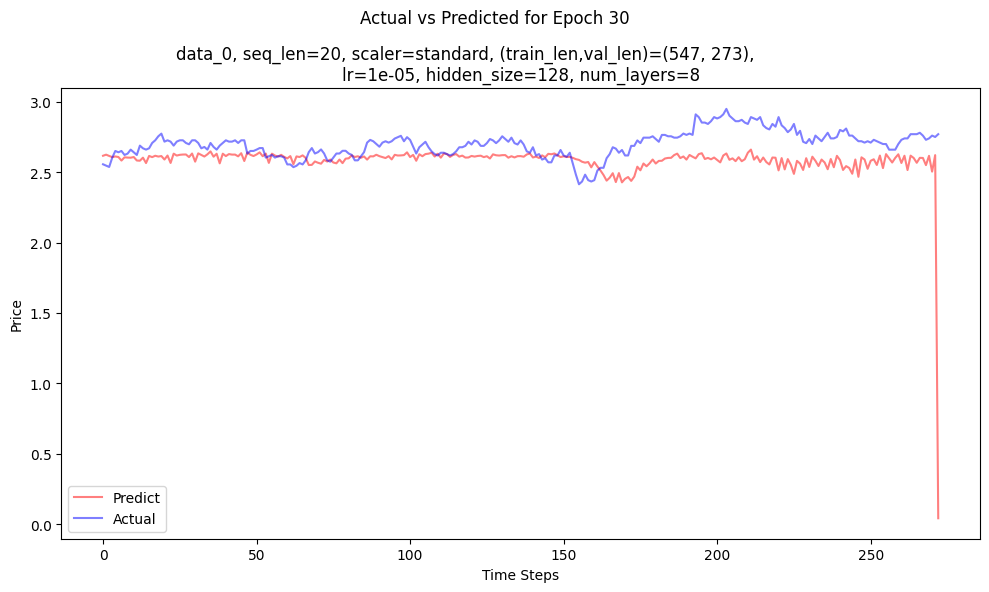

tensor([2.6166, 2.6247, 2.6151, 2.6065, 2.6119, 2.6086, 2.5825, 2.6058],
       device='mps:0')
tensor([2.6040, 2.6029, 2.6074, 2.5824, 2.5821, 2.6047, 2.5659, 2.6165],
       device='mps:0')
tensor([2.6074, 2.6175, 2.6113, 2.6149, 2.5908, 2.6196, 2.5665, 2.6323],
       device='mps:0')
tensor([2.6178, 2.6243, 2.6256, 2.6258, 2.6085, 2.6343, 2.5757, 2.6347],
       device='mps:0')
tensor([2.6221, 2.6126, 2.6280, 2.6482, 2.6109, 2.6324, 2.5631, 2.6319],
       device='mps:0')
tensor([2.6138, 2.6296, 2.6257, 2.6247, 2.6135, 2.6361, 2.5796, 2.6412],
       device='mps:0')
tensor([2.6231, 2.6157, 2.6268, 2.6413, 2.6143, 2.6334, 2.5663, 2.6325],
       device='mps:0')
tensor([2.6175, 2.6122, 2.6238, 2.6085, 2.5983, 2.6152, 2.5559, 2.6121],
       device='mps:0')
tensor([2.6070, 2.6188, 2.6003, 2.5491, 2.5515, 2.5762, 2.5657, 2.5603],
       device='mps:0')
tensor([2.5874, 2.5754, 2.5893, 2.5680, 2.5631, 2.5910, 2.5645, 2.5970],
       device='mps:0')
tensor([2.5987, 2.6199, 2.6080, 2.6127, 

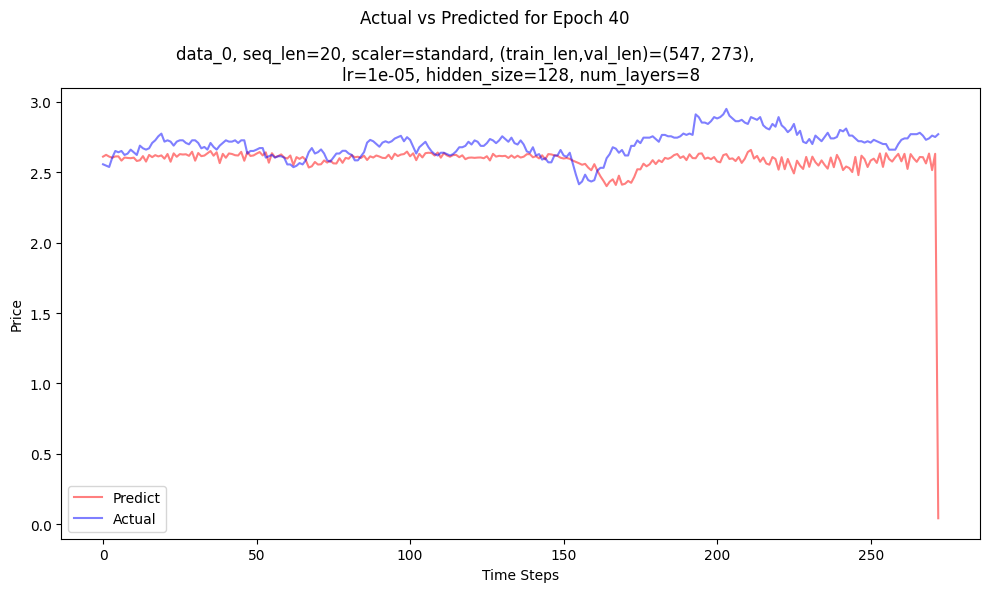

tensor([2.6097, 2.6230, 2.6102, 2.6026, 2.6117, 2.6126, 2.5823, 2.6038],
       device='mps:0')
tensor([2.6007, 2.5988, 2.6030, 2.5796, 2.5849, 2.6149, 2.5764, 2.6231],
       device='mps:0')
tensor([2.6066, 2.6214, 2.6122, 2.6199, 2.5962, 2.6301, 2.5753, 2.6337],
       device='mps:0')
tensor([2.6084, 2.6285, 2.6255, 2.6274, 2.6169, 2.6463, 2.5825, 2.6359],
       device='mps:0')
tensor([2.6129, 2.6181, 2.6344, 2.6504, 2.6175, 2.6426, 2.5645, 2.6297],
       device='mps:0')
tensor([2.6008, 2.6331, 2.6296, 2.6202, 2.6191, 2.6452, 2.5814, 2.6435],
       device='mps:0')
tensor([2.6143, 2.6188, 2.6322, 2.6432, 2.6195, 2.6417, 2.5673, 2.6346],
       device='mps:0')
tensor([2.6047, 2.6135, 2.6264, 2.6036, 2.5969, 2.6186, 2.5494, 2.6062],
       device='mps:0')
tensor([2.5928, 2.6067, 2.5860, 2.5316, 2.5407, 2.5719, 2.5531, 2.5557],
       device='mps:0')
tensor([2.5827, 2.5673, 2.5818, 2.5624, 2.5614, 2.5998, 2.5669, 2.6018],
       device='mps:0')
tensor([2.5952, 2.6215, 2.6057, 2.6097, 

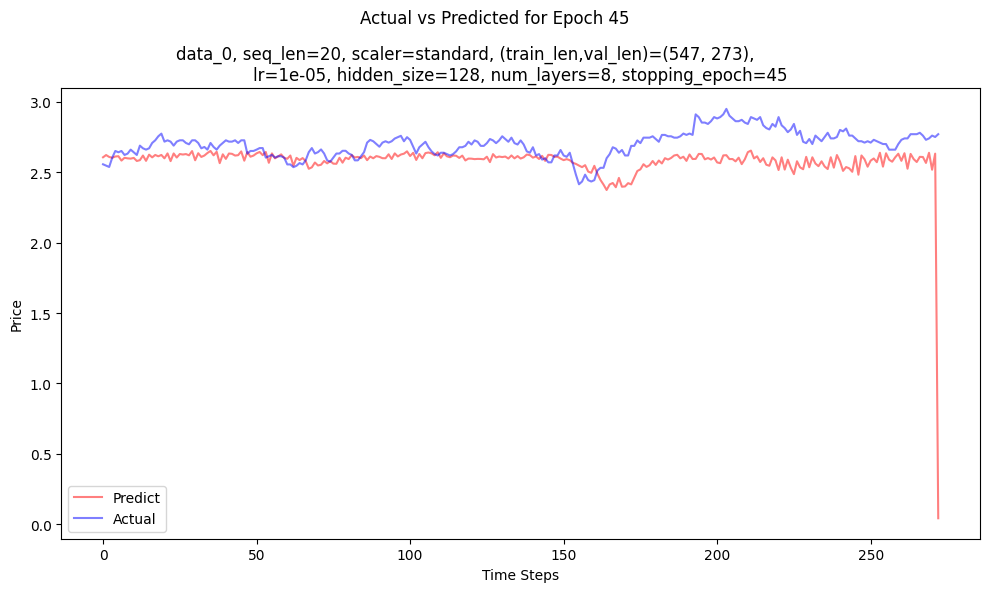

Elapsed time is 2m37s.


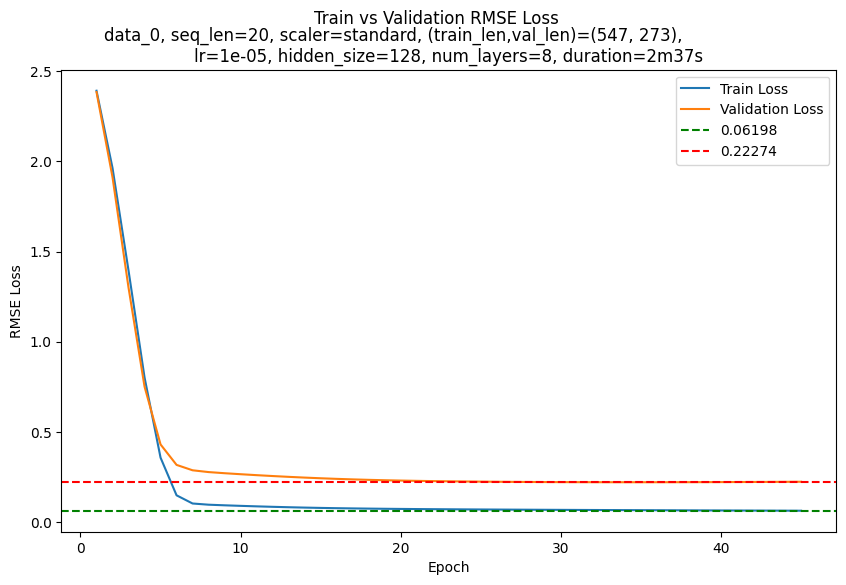

Finished Training
-----Training for data_0, seq_len=20, scaler=standard, (train_len,val_len)=(274, 273), lr=1e-05, hidden_size=128, num_layers=12-----
Train dataloader: batch size: 8, sequence length: 20, n_features: 9.
tensor([ 0.0035, -0.0058, -0.0055,  0.0739, -0.0177,  0.0340, -0.0147, -0.0547],
       device='mps:0')
tensor([ 0.0307,  0.0066,  0.0444,  0.1380, -0.0116,  0.0791,  0.0491,  0.0195],
       device='mps:0')
tensor([ 0.0895,  0.0415,  0.0618,  0.2075, -0.0279,  0.0587,  0.0670, -0.0061],
       device='mps:0')
tensor([ 0.1367,  0.0738,  0.0716,  0.2901,  0.0185,  0.1094,  0.1438, -0.0532],
       device='mps:0')
tensor([ 1.5021e-01,  7.1459e-02,  8.3816e-02,  2.6941e-01,  2.4962e-04,
         7.5141e-02,  1.6219e-01, -8.7225e-02], device='mps:0')
tensor([ 0.1500,  0.0814,  0.0866,  0.2116,  0.0241,  0.0833,  0.1005, -0.0390],
       device='mps:0')
tensor([ 0.1214,  0.0192,  0.0406,  0.0593, -0.0807, -0.0763,  0.0181, -0.1290],
       device='mps:0')
tensor([ 0.0428, -0

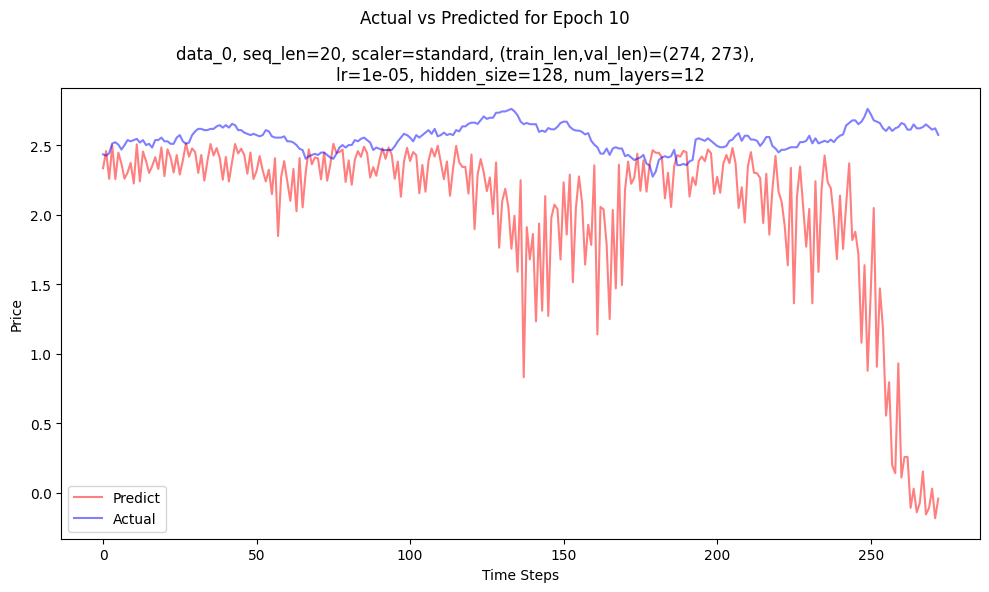

tensor([2.3834, 2.5015, 2.3059, 2.5406, 2.3027, 2.4886, 2.4111, 2.3039],
       device='mps:0')
tensor([2.3546, 2.4206, 2.2740, 2.5476, 2.2858, 2.4969, 2.4313, 2.3439],
       device='mps:0')
tensor([2.3981, 2.4586, 2.3743, 2.5264, 2.3270, 2.5116, 2.4574, 2.3479],
       device='mps:0')
tensor([2.4748, 2.3375, 2.4336, 2.5554, 2.4653, 2.5182, 2.4940, 2.3451],
       device='mps:0')
tensor([2.4745, 2.2933, 2.4287, 2.5498, 2.4731, 2.5209, 2.4549, 2.2964],
       device='mps:0')
tensor([2.4595, 2.2883, 2.4199, 2.5498, 2.4875, 2.5161, 2.4735, 2.3403],
       device='mps:0')
tensor([2.4918, 2.3082, 2.3584, 2.4666, 2.3697, 2.2878, 2.3722, 2.1956],
       device='mps:0')
tensor([2.4520, 1.8986, 2.3159, 2.4310, 2.2919, 2.1517, 2.3776, 2.0728],
       device='mps:0')
tensor([2.4517, 2.1067, 2.3479, 2.5129, 2.4130, 2.4567, 2.4505, 2.3011],
       device='mps:0')
tensor([2.4897, 2.2954, 2.4019, 2.5512, 2.4917, 2.4932, 2.5129, 2.2802],
       device='mps:0')
tensor([2.4346, 2.2632, 2.4379, 2.4998, 

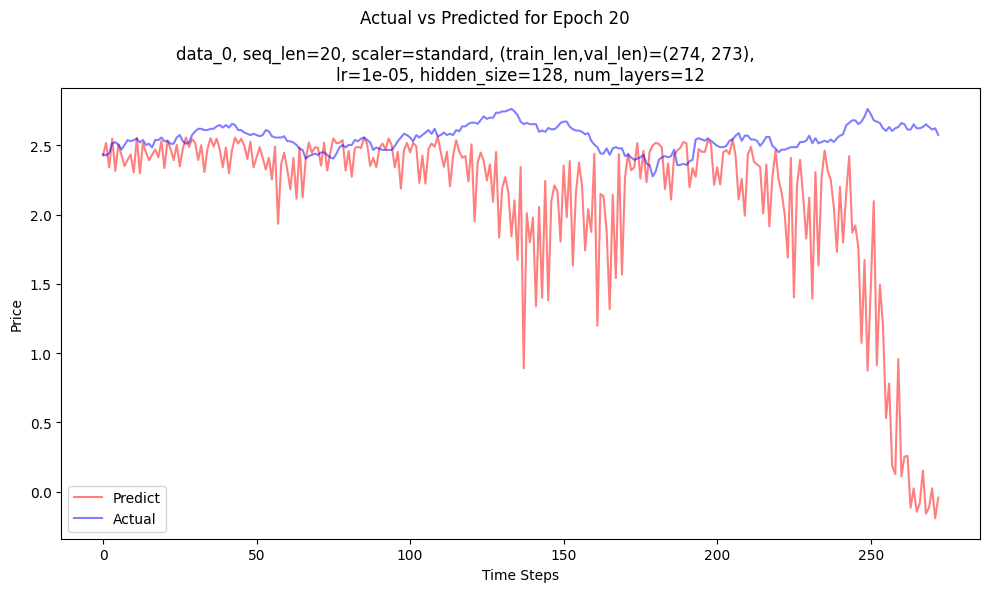

tensor([2.4249, 2.5154, 2.3389, 2.5448, 2.3114, 2.5038, 2.4278, 2.3501],
       device='mps:0')
tensor([2.3946, 2.4303, 2.3015, 2.5498, 2.2952, 2.5142, 2.4445, 2.3931],
       device='mps:0')
tensor([2.4313, 2.4677, 2.4133, 2.5261, 2.3322, 2.5335, 2.4714, 2.3934],
       device='mps:0')
tensor([2.5026, 2.3452, 2.4792, 2.5520, 2.4858, 2.5440, 2.5149, 2.3950],
       device='mps:0')
tensor([2.5003, 2.3043, 2.4743, 2.5467, 2.4904, 2.5468, 2.4692, 2.3420],
       device='mps:0')
tensor([2.4831, 2.2955, 2.4667, 2.5514, 2.5116, 2.5465, 2.4976, 2.4025],
       device='mps:0')
tensor([2.5250, 2.3402, 2.4119, 2.4840, 2.4121, 2.3238, 2.4104, 2.2551],
       device='mps:0')
tensor([2.4913, 1.9325, 2.3639, 2.4439, 2.3231, 2.1806, 2.4063, 2.1139],
       device='mps:0')
tensor([2.4830, 2.1228, 2.3951, 2.5171, 2.4451, 2.4845, 2.4808, 2.3546],
       device='mps:0')
tensor([2.5182, 2.3164, 2.4480, 2.5454, 2.5136, 2.5166, 2.5359, 2.3179],
       device='mps:0')
tensor([2.4578, 2.2698, 2.4811, 2.4843, 

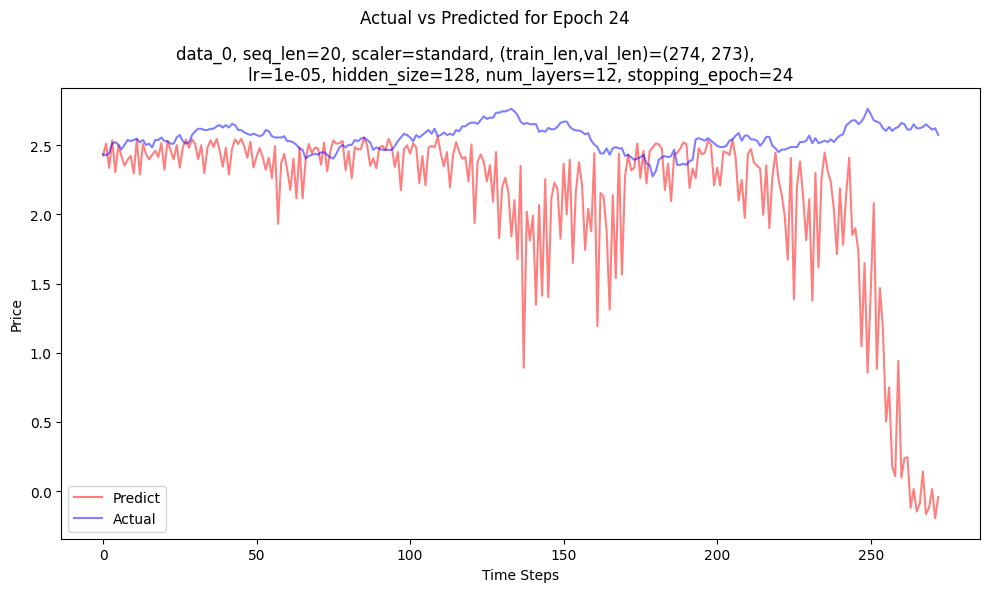

Elapsed time is 1m23s.


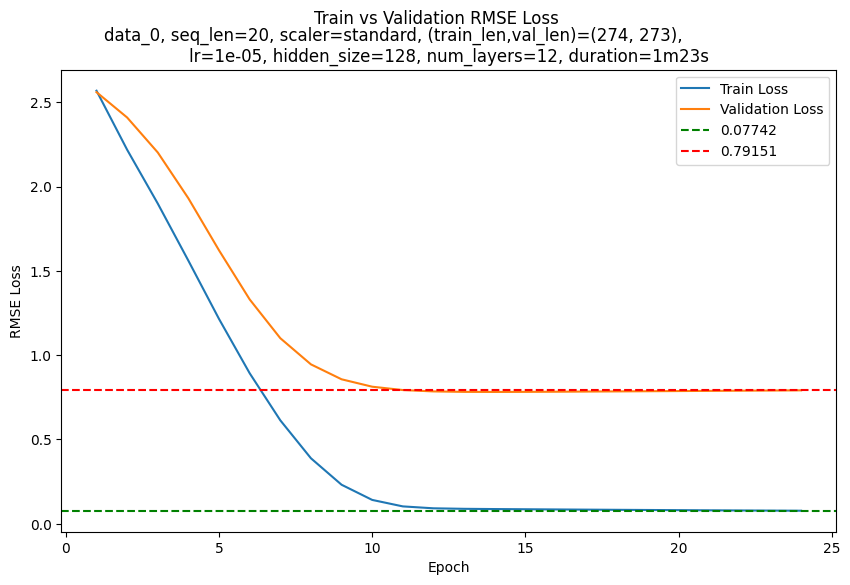

Finished Training
-----Training for data_0, seq_len=20, scaler=standard, (train_len,val_len)=(547, 273), lr=1e-05, hidden_size=128, num_layers=12-----
Train dataloader: batch size: 8, sequence length: 20, n_features: 9.
tensor([0.5335, 0.5519, 0.6797, 0.5151, 0.5615, 0.5295, 0.4527, 0.5982],
       device='mps:0')
tensor([0.5490, 0.5389, 0.6316, 0.4555, 0.5505, 0.4890, 0.4995, 0.5542],
       device='mps:0')
tensor([0.5622, 0.5362, 0.6364, 0.5118, 0.5920, 0.5380, 0.4676, 0.5990],
       device='mps:0')
tensor([0.5278, 0.5397, 0.6326, 0.5210, 0.5617, 0.4861, 0.4034, 0.6030],
       device='mps:0')
tensor([0.4689, 0.4921, 0.6425, 0.5059, 0.5549, 0.4597, 0.4235, 0.6284],
       device='mps:0')
tensor([0.4813, 0.4834, 0.6612, 0.5086, 0.5702, 0.4960, 0.4074, 0.6145],
       device='mps:0')
tensor([0.5240, 0.4907, 0.6371, 0.4853, 0.5481, 0.4389, 0.4388, 0.6032],
       device='mps:0')
tensor([0.4696, 0.4790, 0.6272, 0.4671, 0.5702, 0.4895, 0.4132, 0.5928],
       device='mps:0')
tensor([0.48

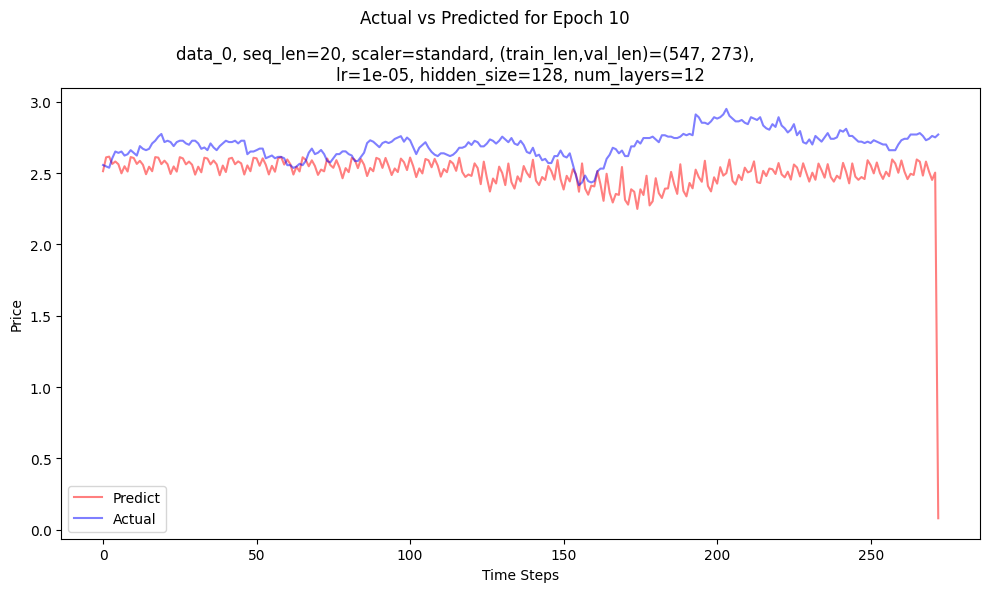

tensor([2.5185, 2.6051, 2.6118, 2.5543, 2.5754, 2.5604, 2.5078, 2.5474],
       device='mps:0')
tensor([2.5161, 2.6078, 2.6015, 2.5552, 2.5803, 2.5563, 2.5013, 2.5455],
       device='mps:0')
tensor([2.5184, 2.6082, 2.6053, 2.5537, 2.5814, 2.5604, 2.5027, 2.5462],
       device='mps:0')
tensor([2.5152, 2.6078, 2.6008, 2.5537, 2.5763, 2.5578, 2.4985, 2.5448],
       device='mps:0')
tensor([2.5110, 2.6050, 2.6009, 2.5543, 2.5846, 2.5618, 2.4946, 2.5536],
       device='mps:0')
tensor([2.5130, 2.5968, 2.6063, 2.5552, 2.5784, 2.5675, 2.4999, 2.5547],
       device='mps:0')
tensor([2.5185, 2.6039, 2.6020, 2.5446, 2.5994, 2.5592, 2.5004, 2.5520],
       device='mps:0')
tensor([2.5152, 2.6002, 2.6119, 2.5535, 2.5920, 2.5621, 2.5001, 2.5458],
       device='mps:0')
tensor([2.5167, 2.6084, 2.5911, 2.5400, 2.5862, 2.5481, 2.4964, 2.5246],
       device='mps:0')
tensor([2.5165, 2.5984, 2.5515, 2.5281, 2.5866, 2.5360, 2.4713, 2.5358],
       device='mps:0')
tensor([2.5107, 2.6029, 2.5901, 2.5251, 

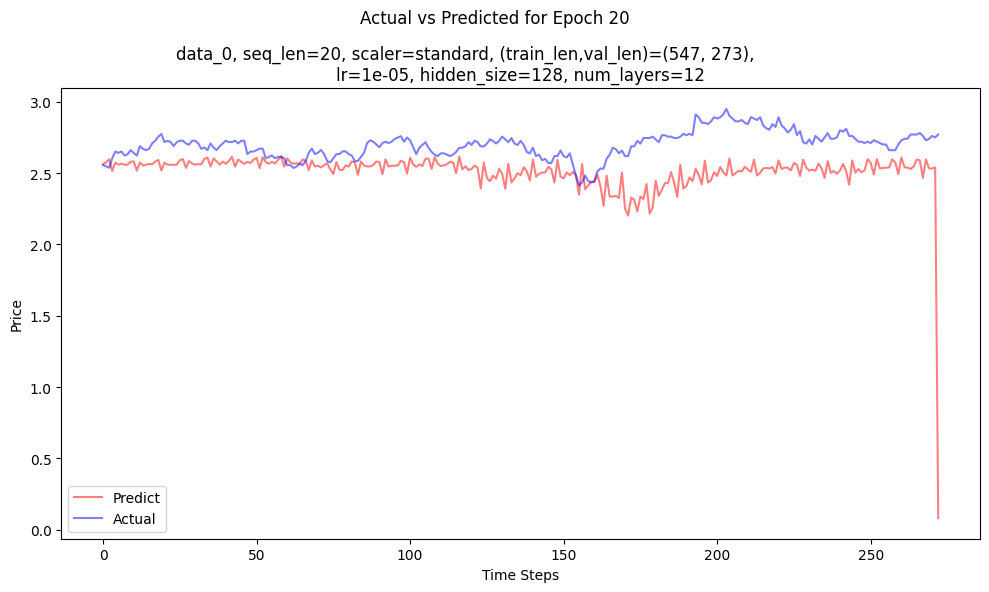

tensor([2.5665, 2.5747, 2.5972, 2.5151, 2.5742, 2.5592, 2.5692, 2.5598],
       device='mps:0')
tensor([2.5629, 2.5777, 2.5818, 2.5173, 2.5750, 2.5533, 2.5615, 2.5657],
       device='mps:0')
tensor([2.5653, 2.5794, 2.5917, 2.5188, 2.5738, 2.5587, 2.5627, 2.5595],
       device='mps:0')
tensor([2.5627, 2.5890, 2.5986, 2.5385, 2.5861, 2.5675, 2.5627, 2.5645],
       device='mps:0')
tensor([2.5652, 2.5997, 2.6109, 2.5491, 2.6053, 2.5834, 2.5634, 2.5835],
       device='mps:0')
tensor([2.5692, 2.5859, 2.6155, 2.5479, 2.5974, 2.5801, 2.5681, 2.5813],
       device='mps:0')
tensor([2.5737, 2.5934, 2.6085, 2.5374, 2.6130, 2.5787, 2.5685, 2.5813],
       device='mps:0')
tensor([2.5709, 2.5938, 2.6198, 2.5479, 2.6056, 2.5751, 2.5693, 2.5711],
       device='mps:0')
tensor([2.5686, 2.5951, 2.5868, 2.5232, 2.5891, 2.5464, 2.5551, 2.5414],
       device='mps:0')
tensor([2.5579, 2.5687, 2.5258, 2.4934, 2.5771, 2.5229, 2.5239, 2.5556],
       device='mps:0')
tensor([2.5476, 2.5797, 2.5743, 2.4883, 

KeyboardInterrupt: 

In [28]:
data_dfs = data_dfs # 3 df # TODO: Changed some params
seq_len_list = [20, 30]
scaler_type_list = ['standard']
lr_list = [0.00001, 0.000001]
hidden_size_list = [128, 256]
num_layers_list = [8, 12]

import itertools
combinations = itertools.product(seq_len_list, scaler_type_list, lr_list, hidden_size_list, num_layers_list)

input("Created new folder for plots? (Just a reminder, no need to input anything)")
for df_id in range(len(data_dfs)):
    for combination in combinations:
        kwargs = {
            'df': data_dfs[df_id],
            'df_id': df_id,
            'seq_len': combination[0],
            'scaler_type': combination[1],
            'lr': combination[2],
            'hidden_size': combination[3],
            'num_layers': combination[4]
        }
        
        hp_tuning(**kwargs)


In [ ]:
# Assigned to Bryan
# data_dfs = data_dfs # 3 df
# seq_len_list = [10, 20, 30]
# scaler_type_list = ['standard', 'minmax']
# lr_list = [0.0001, 0.00001, 0.000001]
# hidden_size_list = [64, 128, 256]
# num_layers_list = [4, 8, 12]

# import itertools
# combinations = itertools.product(seq_len_list, scaler_type_list, lr_list, hidden_size_list, num_layers_list)

# input("Created new folder for plots?")
# for df_id in range(2, len(data_dfs)):
#     for combination in combinations:
#         kwargs = {
#             'df': data_dfs[df_id],
#             'df_id': df_id,
#             'seq_len': combination[0],
#             'scaler_type': combination[1],
#             'lr': combination[2],
#             'hidden_size': combination[3],
#             'num_layers': combination[4]
#         }
        
#         hp_tuning(**kwargs)
